In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import torch
import numpy as np

knock70

In [ ]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors

d = 300
L = 4

def preprc(data):
  x = []
  y = []
  label = {"b":0, "e":2, "t":1, "m":3} #ビジネス:0, エンターテインメント:2, 科学技術:1, 健康:3
  for l in data:
    da = l.split("\t")
    # titleを数字をすべて0、アルファベットを小文字にする
    xd = [i.rstrip("\n").strip(":'$%?,.()!;").strip('"') for i in re.sub("[0-9]+", "0", da[1]).lower().split(" ") if i != "" and i != "...\n"]
    emb_sum = torch.zeros((d,))
    nd = 0
    for w in xd:
      if not w in model.key_to_index:
        nd += 1
        #print(w)
      else:
        emb_sum += torch.from_numpy(model[w])
    if (len(xd) - nd) != 0:
      x.append(emb_sum / (len(xd) - nd))
      y.append(label[da[0]])
  return torch.stack(x), torch.tensor(y)

train = []
valid = []
test = []
with open('/content/drive/MyDrive/train.txt', encoding='utf-8') as f:
  for l in f:
    train.append(l)
with open('/content/drive/MyDrive/valid.txt', encoding='utf-8') as f:
  for l in f:
    valid.append(l)
with open('/content/drive/MyDrive/test.txt', encoding='utf-8') as f:
  for l in f:
    test.append(l)
X_train, Y_train = preprc(train)
X_valid, Y_valid = preprc(valid)
X_test, Y_test = preprc(test)

<ipython-input-4-7aa742f11a13>:24: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  emb_sum += torch.from_numpy(model[w])


In [ ]:
np.save('/content/drive/MyDrive/X_train.npy', X_train.numpy())
np.save('/content/drive/MyDrive/Y_train.npy', Y_train.numpy())
np.save('/content/drive/MyDrive/X_valid.npy', X_valid.numpy())
np.save('/content/drive/MyDrive/Y_valid.npy', Y_valid.numpy())
np.save('/content/drive/MyDrive/X_test.npy', X_test.numpy())
np.save('/content/drive/MyDrive/Y_test.npy', Y_test.numpy())

knock71

In [22]:
def read_f():
  X_train = torch.from_numpy(np.load('/content/drive/MyDrive/X_train.npy'))
  Y_train = torch.from_numpy(np.load('/content/drive/MyDrive/Y_train.npy'))
  X_valid = torch.from_numpy(np.load('/content/drive/MyDrive/X_valid.npy'))
  Y_valid = torch.from_numpy(np.load('/content/drive/MyDrive/Y_valid.npy'))
  X_test = torch.from_numpy(np.load('/content/drive/MyDrive/X_test.npy'))
  Y_test = torch.from_numpy(np.load('/content/drive/MyDrive/Y_test.npy'))
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = read_f()
W = torch.randn(d, L, requires_grad=True)

In [ ]:
yh1 = torch.softmax(X_train[0] @ W, dim=-1)
Yh = torch.softmax(X_train[:4] @ W, dim=-1)
print(f"{yh1}")
print(f"{Yh}")

tensor([0.0361, 0.8235, 0.0983, 0.0421], grad_fn=<SoftmaxBackward0>)
tensor([[0.0361, 0.8235, 0.0983, 0.0421],
        [0.3200, 0.4965, 0.1014, 0.0820],
        [0.0074, 0.9824, 0.0052, 0.0051],
        [0.0338, 0.1247, 0.0336, 0.8079]], grad_fn=<SoftmaxBackward0>)


knock72

In [ ]:
from torch import nn

class SLPN(nn.Module):
  def __init__(self, ins, outs):
    super().__init__()
    self.fc = nn.Linear(ins, outs, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)
  def forward(self, x):
    return self.fc(x)

n_W = SLPN(d, L)

criterion = torch.nn.CrossEntropyLoss()
l1 = criterion(n_W(X_train[0]), Y_train[0])
n_W.zero_grad()
l1.backward()
print(f"x1のクロスエントロピー損失：{l1}")
print(f"x1の行列Wに対する勾配：\n{n_W.fc.weight.grad}")
l = criterion(n_W(X_train[:4]), Y_train[:4])
n_W.zero_grad()
l.backward()
print(f"\n事例集合x1,x2,x3,x4のクロスエントロピー損失：{l}")
print(f"事例集合x1,x2,x3,x4の行列Wに対する勾配：\n{n_W.fc.weight.grad}")

x1のクロスエントロピー損失：1.216619849205017
x1の行列Wに対する勾配：
tensor([[-1.1139e-02,  1.8192e-02,  5.4603e-05,  ..., -6.9299e-03,
          2.2373e-02,  1.1984e-02],
        [-8.0246e-04,  1.3105e-03,  3.9336e-06,  ..., -4.9923e-04,
          1.6118e-03,  8.6334e-04],
        [ 2.5193e-02, -4.1144e-02, -1.2349e-04,  ...,  1.5673e-02,
         -5.0601e-02, -2.7104e-02],
        [-1.3251e-02,  2.1642e-02,  6.4958e-05,  ..., -8.2440e-03,
          2.6616e-02,  1.4257e-02]])

事例集合x1,x2,x3,x4のクロスエントロピー損失：1.7574491500854492
事例集合x1,x2,x3,x4の行列Wに対する勾配：
tensor([[ 0.0048,  0.0108, -0.0044,  ..., -0.0069, -0.0447,  0.0178],
        [ 0.0054, -0.0282, -0.0068,  ..., -0.0216, -0.0015,  0.0314],
        [ 0.0074, -0.0135,  0.0119,  ...,  0.0312,  0.0451, -0.0455],
        [-0.0176,  0.0308, -0.0007,  ..., -0.0026,  0.0011, -0.0037]])


knock73

In [ ]:
optimizer = torch.optim.SGD(n_W.parameters(), lr=0.1)

for epoch in range(100):
  n_W.train()
  loss_train = 0.0
  for i, nt in enumerate(X_train):
    la = Y_train[i]
    optimizer.zero_grad()
    loss = criterion(n_W(nt), la)
    loss.backward()
    optimizer.step()
    loss_train += loss.item()
  loss_train = loss_train / (i + 1)
  n_W.eval()
  with torch.no_grad():
    loss_valid = criterion(n_W(X_valid), Y_valid)
  if (epoch + 1) % 10 == 0:
    print(f"epoch: {epoch+1}, loss_train: {loss_train}, loss_valid: {loss_valid}")

epoch: 10, loss_train: 0.30480048425967354, loss_valid: 0.35945838689804077
epoch: 20, loss_train: 0.2920474224796067, loss_valid: 0.364530086517334
epoch: 30, loss_train: 0.28777381823548637, loss_valid: 0.3701413571834564
epoch: 40, loss_train: 0.2857675834646955, loss_valid: 0.3745409846305847
epoch: 50, loss_train: 0.28466023647596, loss_valid: 0.3778628408908844
epoch: 60, loss_train: 0.2839859274206515, loss_valid: 0.3803853392601013
epoch: 70, loss_train: 0.2835472520508062, loss_valid: 0.38232603669166565
epoch: 80, loss_train: 0.28324794081037064, loss_valid: 0.383841335773468
epoch: 90, loss_train: 0.2830362716822631, loss_valid: 0.38504019379615784
epoch: 100, loss_train: 0.2828823371153802, loss_valid: 0.3860011696815491


knock74

In [ ]:
def cal_acc(model, x, y):
  model.eval()
  cor = 0
  with torch.no_grad():
    for i, input in enumerate(x):
      pred = torch.argmax(n_W(input), dim=-1)
      cor += (pred == y[i]).sum().item()
  return cor / len(x)

acc_train = cal_acc(n_W, X_train, Y_train)
acc_test = cal_acc(n_W, X_test, Y_test)
print(f"学習データの正解率：{acc_train}")
print(f"評価データの正解率：{acc_test}")

学習データの正解率：0.9036031820308844
評価データの正解率：0.8779026217228464


knock75

In [ ]:
def cal_loss(model, x, y, criterion):
  model.eval()
  loss = 0.0
  cor = 0
  with torch.no_grad():
    for i, input in enumerate(x):
      loss += criterion(model(input), y[i]).item()
  return loss / len(x)

n_W = SLPN(d, L)
optimizer = torch.optim.SGD(n_W.parameters(), lr=0.1)
losss_train = []
accs_train = []
losss_valid = []
accs_valid =[]
for epoch in range(100):
  n_W.train()
  for i, nt in enumerate(X_train):
    la = Y_train[i]
    optimizer.zero_grad()
    loss = criterion(n_W(nt), la)
    loss.backward()
    optimizer.step()
  losss_train.append(cal_loss(n_W, X_train, Y_train, criterion))
  accs_train.append(cal_acc(n_W, X_train, Y_train))
  losss_valid.append(cal_loss(n_W, X_valid, Y_valid, criterion))
  accs_valid.append(cal_acc(n_W, X_valid, Y_valid))

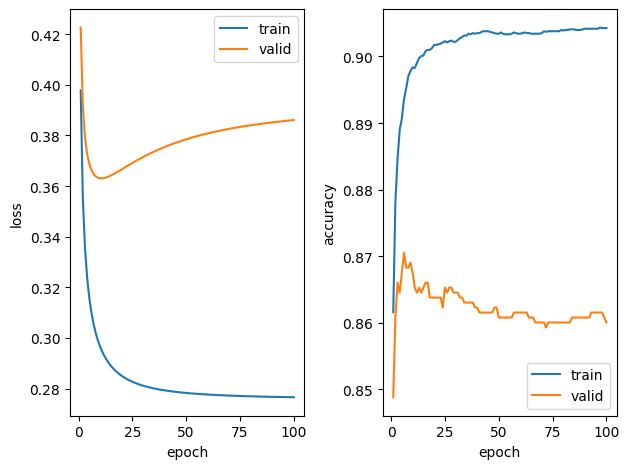

In [ ]:
import matplotlib.pyplot as plt

plt.figure(tight_layout=True)
plt.subplot(121)
plt.plot(range(1,101), losss_train, label="train")
plt.plot(range(1,101), losss_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel('loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1,101), accs_train, label="train")
plt.plot(range(1,101), accs_valid, label="valid")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

knock76

In [ ]:
n_W = SLPN(d, L)
optimizer = torch.optim.SGD(n_W.parameters(), lr=0.1)
losss_train = []
accs_train = []
losss_valid = []
accs_valid =[]
with open('k76.txt', 'w') as f:
  for epoch in range(100):
    n_W.train()
    for i, nt in enumerate(X_train):
      la = Y_train[i]
      optimizer.zero_grad()
      loss = criterion(n_W(nt), la)
      loss.backward()
      optimizer.step()
    f.write(f'{epoch+1}\n{n_W.state_dict()}\n{optimizer.state_dict()}')

knock77

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

dataset_train = NewsDataset(X_train, Y_train)
dataset_valid = NewsDataset(X_valid, Y_valid)
dataset_test = NewsDataset(X_test, Y_test)

dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [ ]:
import time

def cal_laa(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time()
    model.train()
    for inputs, labels in dataloader_train:
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    loss_train, acc_train = cal_laa(model, criterion, dataloader_train)
    loss_valid, acc_valid = cal_laa(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

n_W = SLPN(300, 4)
optimizer = torch.optim.SGD(n_W.parameters(), lr=1e-1)

for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, n_W, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.4017, accuracy_train: 0.8633, loss_valid: 0.4266, accuracy_valid: 0.8466, 4.7287sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3758, accuracy_train: 0.8715, loss_valid: 0.4098, accuracy_valid: 0.8518, 2.5810sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3647, accuracy_train: 0.8773, loss_valid: 0.4006, accuracy_valid: 0.8578, 1.3243sec
バッチサイズ: 8
epoch: 1, loss_train: 0.3602, accuracy_train: 0.8789, loss_valid: 0.3976, accuracy_valid: 0.8593, 0.7469sec
バッチサイズ: 16
epoch: 1, loss_train: 0.3583, accuracy_train: 0.8795, loss_valid: 0.3964, accuracy_valid: 0.8600, 0.5787sec
バッチサイズ: 32
epoch: 1, loss_train: 0.3575, accuracy_train: 0.8799, loss_valid: 0.3957, accuracy_valid: 0.8600, 0.4367sec
バッチサイズ: 64
epoch: 1, loss_train: 0.3570, accuracy_train: 0.8794, loss_valid: 0.3953, accuracy_valid: 0.8600, 0.3483sec
バッチサイズ: 128
epoch: 1, loss_train: 0.3563, accuracy_train: 0.8796, loss_valid: 0.3951, accuracy_valid: 0.8608, 0.2793sec
バッチサイズ: 256
epoch: 1, loss_train: 0.3572, accuracy_

knock78

In [ ]:
def cal_laa(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  model.to(device)

  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time()
    model.train()
    for inputs, labels in dataloader_train:
      optimizer.zero_grad()

      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    loss_train, acc_train = cal_laa(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = cal_laa(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [ ]:
n_W = SLPN(300, 4)
optimizer = torch.optim.SGD(n_W.parameters(), lr=1e-1)
device = torch.device('cuda')

for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, n_W, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.4122, accuracy_train: 0.8579, loss_valid: 0.4276, accuracy_valid: 0.8458, 10.8607sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3784, accuracy_train: 0.8702, loss_valid: 0.4012, accuracy_valid: 0.8488, 5.6516sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3681, accuracy_train: 0.8728, loss_valid: 0.3937, accuracy_valid: 0.8570, 2.7943sec
バッチサイズ: 8
epoch: 1, loss_train: 0.3629, accuracy_train: 0.8752, loss_valid: 0.3908, accuracy_valid: 0.8563, 1.4435sec
バッチサイズ: 16
epoch: 1, loss_train: 0.3605, accuracy_train: 0.8767, loss_valid: 0.3889, accuracy_valid: 0.8555, 0.7832sec
バッチサイズ: 32
epoch: 1, loss_train: 0.3595, accuracy_train: 0.8767, loss_valid: 0.3883, accuracy_valid: 0.8555, 0.4476sec
バッチサイズ: 64
epoch: 1, loss_train: 0.3590, accuracy_train: 0.8768, loss_valid: 0.3880, accuracy_valid: 0.8563, 0.2960sec
バッチサイズ: 128
epoch: 1, loss_train: 0.3578, accuracy_train: 0.8768, loss_valid: 0.3878, accuracy_valid: 0.8563, 0.2073sec
バッチサイズ: 256
epoch: 1, loss_train: 0.3592, accuracy

knock79

In [ ]:
from torch.nn import functional as F
from torch import optim

class MLPN(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size)
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  model.to(device)

  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    s_time = time.time()
    model.train()
    for inputs, labels in dataloader_train:
      optimizer.zero_grad()
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    e_time = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [ ]:
n_W = MLPN(300, 200, 4, 1)
optimizer = torch.optim.SGD(n_W.parameters(), lr=1e-3)
device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, 64, n_W, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 0.9703, accuracy_train: 0.7250, loss_valid: 0.9595, accuracy_valid: 0.7268, 0.6519sec
epoch: 2, loss_train: 0.7690, accuracy_train: 0.7567, loss_valid: 0.7618, accuracy_valid: 0.7575, 0.8265sec
epoch: 3, loss_train: 0.6896, accuracy_train: 0.7659, loss_valid: 0.6837, accuracy_valid: 0.7635, 0.6059sec
epoch: 4, loss_train: 0.6441, accuracy_train: 0.7763, loss_valid: 0.6398, accuracy_valid: 0.7740, 0.5640sec
epoch: 5, loss_train: 0.6091, accuracy_train: 0.7845, loss_valid: 0.6071, accuracy_valid: 0.7792, 0.4525sec
epoch: 6, loss_train: 0.5859, accuracy_train: 0.7956, loss_valid: 0.5846, accuracy_valid: 0.7897, 0.4657sec
epoch: 7, loss_train: 0.5636, accuracy_train: 0.8000, loss_valid: 0.5636, accuracy_valid: 0.7964, 0.4470sec
epoch: 8, loss_train: 0.5482, accuracy_train: 0.8063, loss_valid: 0.5495, accuracy_valid: 0.8031, 0.4588sec
epoch: 9, loss_train: 0.5315, accuracy_train: 0.8117, loss_valid: 0.5333, accuracy_valid: 0.8024, 0.4455sec
epoch: 10, loss_train: 0.521

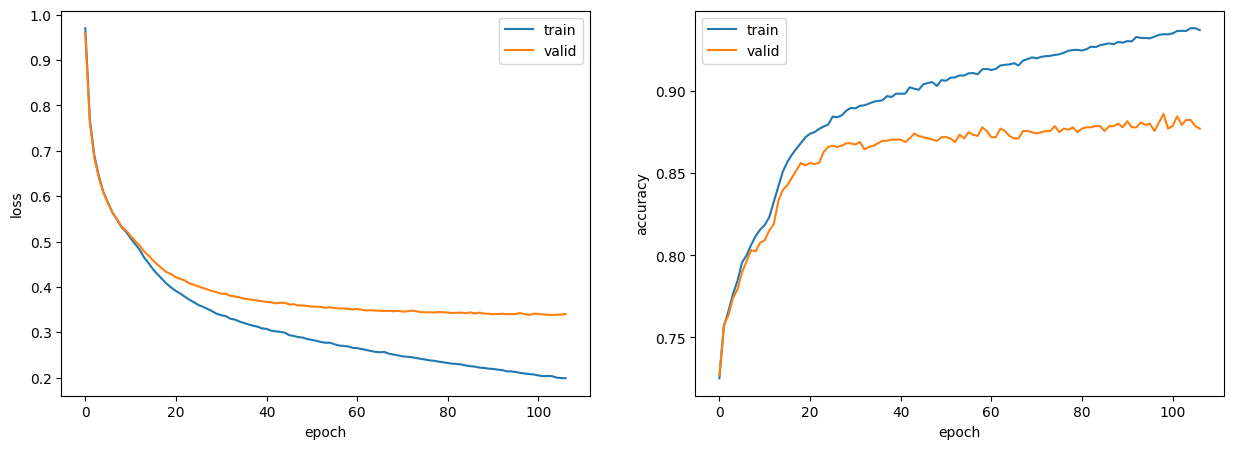

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [24]:
def cal_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

acc_train = cal_accuracy(n_W, dataloader_train, device)
acc_test = cal_accuracy(n_W, dataloader_test, device)
print(f'学習データの正解率：{acc_train:.3f}')
print(f'評価データの正解率：{acc_test:.3f}')

学習データの正解率：0.937
評価データの正解率：0.883
